In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [3]:
import torch
import torchtuples as tt

In [5]:
from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.models import PMF
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [6]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [7]:
df_train = metabric.read_df()

In [8]:
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [10]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [29]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

In [30]:
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [36]:
x_mapper

DataFrameMapper(drop_cols=[],
                features=[(['x0'], StandardScaler()),
                          (['x1'], StandardScaler()),
                          (['x2'], StandardScaler()),
                          (['x3'], StandardScaler()),
                          (['x8'], StandardScaler()), ('x4', None),
                          ('x5', None), ('x6', None), ('x7', None)])

In [38]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Label transforms

In [46]:
df_train[['duration', 'event']].head()

,duration,event
0,99.333336,0
1,95.733330,1
3,239.300003,0
4,56.933334,1
5,123.533333,0


In [47]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [15]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

In [63]:
print(labtrans, labtrans.cuts, sep='\n')

[  0.        39.466667  78.933334 118.4      157.86667  197.33334
 236.8      276.26666  315.73334  355.2     ]


In [64]:
y_train

(array([2, 3, 6, ..., 1, 5, 3]),
 array([0., 1., 0., ..., 1., 0., 0.], dtype=float32))

In [65]:
labtrans.cuts[y_train[0]]

array([ 78.933334, 118.4     , 236.8     , ...,  39.466667, 197.33334 ,
       118.4     ], dtype=float32)

In [69]:
print(x_train.shape[1], labtrans.out_features, sep='\n')

9
10


In [74]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [75]:
net

MLPVanilla(
  (net): Sequential(
    (0): DenseVanillaBlock(
      (linear): Linear(in_features=9, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): DenseVanillaBlock(
      (linear): Linear(in_features=32, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [76]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),

    torch.nn.Linear(32, out_features)
)

In [77]:
net

Sequential(
  (0): Linear(in_features=9, out_features=32, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.1, inplace=False)
  (8): Linear(in_features=32, out_features=10, bias=True)
)

## Training the model

1. Define an optimizer
2. duration_index
3. LogisticHazard

In [78]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

/home/liucj/github/TEP-prognosis/venv/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Set Batch_size and the number of training epochs

## Use EarlyStopping callback to stop training when the validation loss stops improving.

In [81]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [83]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

33:	[1s / 1s],		train_loss: 1.3295,	val_loss: 1.3415
34:	[0s / 2s],		train_loss: 1.3167,	val_loss: 1.3470
35:	[1s / 3s],		train_loss: 1.3034,	val_loss: 1.3504
36:	[1s / 4s],		train_loss: 1.2982,	val_loss: 1.3618
37:	[1s / 5s],		train_loss: 1.2991,	val_loss: 1.3593
38:	[0s / 6s],		train_loss: 1.2942,	val_loss: 1.3708
39:	[0s / 7s],		train_loss: 1.2805,	val_loss: 1.3776
40:	[0s / 7s],		train_loss: 1.2676,	val_loss: 1.3764
41:	[0s / 8s],		train_loss: 1.2551,	val_loss: 1.3768
42:	[1s / 9s],		train_loss: 1.2519,	val_loss: 1.3857
43:	[0s / 10s],		train_loss: 1.2515,	val_loss: 1.4024


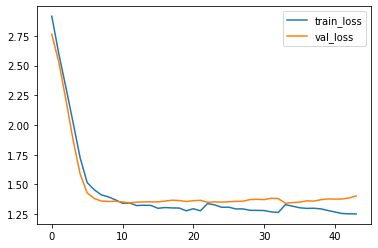

In [84]:
_ = log.plot()

In [85]:
log.to_pandas().val_loss.min()

1.3414785861968994

In [86]:
model.score_in_batches(val)

{'loss': 1.3414785861968994}

## Prediction

In [93]:
df_train['event'].unique()

array([0, 1], dtype=int32)

In [87]:
surv = model.predict_surv_df(x_test)

In [98]:
df_test

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
364,5.505141,8.638374,10.849506,6.638455,0.0,0.0,0.0,1.0,80.330002,69.099998,1
577,5.567882,5.459702,13.863100,6.231246,0.0,1.0,1.0,0.0,46.759998,35.633335,1
1238,5.933456,6.357396,11.204230,5.982156,0.0,0.0,0.0,1.0,50.070000,252.966660,0
329,5.343498,5.601614,11.148868,6.159947,1.0,1.0,0.0,1.0,63.430000,222.199997,0
1185,5.970478,5.847399,11.653483,5.646510,0.0,0.0,0.0,1.0,81.760002,107.766670,1
...,...,...,...,...,...,...,...,...,...,...,...
406,6.782299,5.091162,10.215861,5.744967,1.0,0.0,0.0,0.0,67.199997,73.833336,1
681,6.084165,6.688941,9.628528,5.634579,1.0,1.0,0.0,1.0,82.169998,15.200000,1
1428,5.270206,5.263001,10.920432,6.095256,1.0,0.0,1.0,1.0,63.709999,46.666668,1
1627,5.716135,6.039093,13.800596,6.144595,0.0,1.0,1.0,0.0,37.849998,98.699997,1


In [96]:
surv

,0,1,2,3,4,5,6,7,8,9,...,371,372,373,374,375,376,377,378,379,380
0.000000,0.996877,0.998791,0.991433,0.996362,0.990823,0.990649,0.996451,0.998941,0.992988,0.990428,...,0.994846,0.991820,0.998619,0.997359,0.993813,0.994135,0.996532,0.984061,0.993246,0.982577
39.466667,0.898969,0.837652,0.905591,0.934717,0.780239,0.919686,0.958515,0.990093,0.792765,0.555236,...,0.921055,0.750596,0.885863,0.955198,0.886552,0.861476,0.892079,0.633424,0.774531,0.734441
78.933334,0.735197,0.730749,0.748965,0.787119,0.526579,0.744382,0.857470,0.961351,0.520092,0.335836,...,0.840289,0.424945,0.742612,0.883741,0.693580,0.755504,0.656142,0.322193,0.590015,0.329587
118.400002,0.576715,0.669658,0.636711,0.662840,0.277533,0.647206,0.786901,0.933539,0.301429,0.273585,...,0.754574,0.177552,0.602314,0.839885,0.570435,0.576484,0.340312,0.213439,0.519028,0.147612
157.866669,0.374575,0.509421,0.566281,0.586713,0.131345,0.564809,0.733753,0.900554,0.195412,0.229583,...,0.678252,0.072260,0.497952,0.796152,0.504437,0.472052,0.149834,0.147374,0.437952,0.069296
197.333344,0.238606,0.502010,0.531420,0.515166,0.055213,0.406864,0.639465,0.781579,0.062863,0.189653,...,0.595575,0.015864,0.412814,0.752321,0.433557,0.373402,0.065555,0.114734,0.423641,0.025031
236.800003,0.114583,0.463834,0.411632,0.302835,0.016461,0.307754,0.486699,0.603608,0.011602,0.126089,...,0.411392,0.002457,0.159681,0.681729,0.251489,0.163446,0.013799,0.061906,0.383299,0.009787
276.266663,0.025778,0.217970,0.273052,0.134223,0.003660,0.208563,0.339533,0.333079,0.000708,0.037062,...,0.263323,0.000098,0.012542,0.581694,0.113949,0.064964,0.000823,0.016007,0.208487,0.001598
315.733337,0.009324,0.019107,0.067800,0.028312,0.001591,0.100151,0.169150,0.287738,0.000201,0.006908,...,0.108376,0.000034,0.001567,0.361864,0.017671,0.021523,0.000383,0.001493,0.028201,0.001008
355.200012,0.003759,0.002392,0.003522,0.001035,0.000425,0.015723,0.006476,0.047193,0.000080,0.002712,...,0.005213,0.000025,0.000215,0.030071,0.001123,0.002481,0.000302,0.000382,0.003538,0.000504


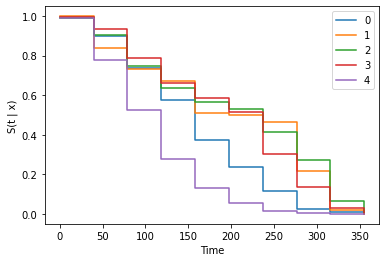

In [88]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [99]:
surv = model.interpolate(10).predict_surv_df(x_test)

In [100]:
surv

,0,1,2,3,4,5,6,7,8,9,...,371,372,373,374,375,376,377,378,379,380
0.000000,0.996877,0.998791,0.991433,0.996362,0.990823,0.990649,0.996451,0.998941,0.992988,0.990428,...,0.994846,0.991820,0.998619,0.997359,0.993813,0.994135,0.996532,0.984061,0.993246,0.982577
3.946667,0.987086,0.982677,0.982849,0.990197,0.969765,0.983553,0.992657,0.998056,0.972965,0.946909,...,0.987467,0.967698,0.987343,0.993143,0.983087,0.980869,0.986087,0.948997,0.971375,0.957763
7.893333,0.977295,0.966563,0.974265,0.984033,0.948706,0.976457,0.988864,0.997172,0.952943,0.903390,...,0.980088,0.943575,0.976067,0.988927,0.972361,0.967603,0.975642,0.913933,0.949503,0.932950
11.840000,0.967504,0.950449,0.965681,0.977868,0.927648,0.969360,0.985070,0.996287,0.932921,0.859871,...,0.972709,0.919453,0.964792,0.984711,0.961635,0.954337,0.965196,0.878870,0.927632,0.908136
15.786667,0.957714,0.934335,0.957096,0.971704,0.906589,0.962264,0.981276,0.995402,0.912899,0.816351,...,0.965330,0.895330,0.953516,0.980494,0.950909,0.941071,0.954751,0.843806,0.905760,0.883322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339.413342,0.005985,0.009078,0.029233,0.011946,0.000892,0.049494,0.071546,0.143411,0.000129,0.004391,...,0.046478,0.000029,0.000756,0.162788,0.007742,0.010097,0.000335,0.000827,0.013403,0.000705
343.360010,0.005428,0.007406,0.022805,0.009218,0.000775,0.041051,0.055278,0.119357,0.000117,0.003971,...,0.036162,0.000028,0.000620,0.129609,0.006088,0.008193,0.000326,0.000715,0.010937,0.000655
347.306677,0.004872,0.005735,0.016378,0.006490,0.000658,0.032609,0.039011,0.095302,0.000105,0.003551,...,0.025846,0.000027,0.000485,0.096430,0.004433,0.006289,0.000318,0.000604,0.008470,0.000604
351.253345,0.004315,0.004063,0.009950,0.003763,0.000542,0.024166,0.022744,0.071248,0.000092,0.003132,...,0.015530,0.000026,0.000350,0.063251,0.002778,0.004385,0.000310,0.000493,0.006004,0.000554


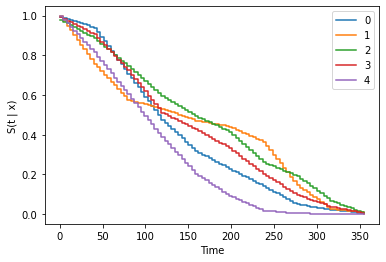

In [28]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [105]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [102]:
ev

In [106]:
ev.concordance_td('antolini')

/home/liucj/github/TEP-prognosis/venv/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 7000. The TBB threading layer is disabled.
  warnings.warn(problem)


0.6572978930857604

In [108]:
durations_test.min(), durations_test.max()

(0.0, 330.36667)

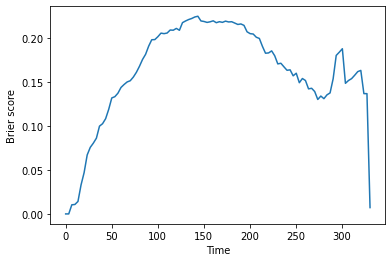

In [109]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

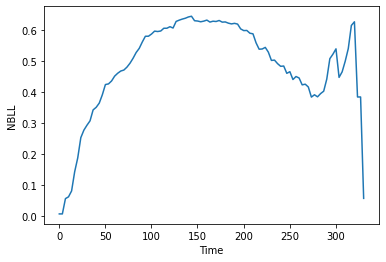

In [110]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [111]:
ev.integrated_brier_score(time_grid) 

0.1628339803169733

In [112]:
ev.integrated_nbll(time_grid) 

0.4866671155387413